# Get Bank of America locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

## Read data

#### Pull all the locations from the company's locator

In [4]:
headers = {
    "authority": "maps.bankofamerica.com",
    "origin": "https://locators.bankofamerica.com",
    "referer": "https://locators.bankofamerica.com/",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
}

#### Snag a list of one zip code for each state

In [5]:
zips = pd.read_csv("data/raw/zips_reference.csv", dtype={"zip": str}).sort_values(
    "pop2012", ascending=False
)

#### Make a list of the most-populous 3000 ZIP Codes

In [6]:
zips_list = zips["zip"].head(3000).to_list()

#### Loop through the list to set a search radius in each state (takes ~20 mins)

In [7]:
urls_list = []
data_list = []

for z in zips_list:
    urls_list.append(
        f"https://maps.bankofamerica.com/api/getAsyncLocations?&template=search&level=search&search={z}&radius=100&limit=100"
    )

for u in tqdm(urls_list):
    response = requests.get(u, headers=headers)

    try:
        markers = response.json()["markers"]
        for m in markers:
            data_dict = {
                "lat": m["lat"],
                "lon": m["lng"],
                "info": m["info"],
                "id": m["locationId"],
            }
            data_list.append(data_dict)
    except (KeyError, TypeError):
        # Handle the case where 'markers' key is not present or response is not JSON
        continue

  0%|          | 0/3000 [00:00<?, ?it/s]

In [8]:
src = pd.DataFrame(data_list).drop_duplicates()

In [9]:
# Function to extract JSON from HTML string
def extract_json(html_string):
    soup = BeautifulSoup(html_string, "html.parser")
    json_string = soup.div.text
    return json.loads(json_string)


# Apply the function to the 'info' column
src["json_data"] = src["info"].apply(extract_json)

# Create a new DataFrame with the extracted JSON data
src_df = pd.json_normalize(src["json_data"])

# Combine the original DataFrame and the new DataFrame
df = (
    pd.concat([src, src_df], axis=1)
    .drop(["info", "json_data"], axis=1)
    .drop_duplicates()
)

df.columns = [
    "lat",
    "lon",
    "id",
    "fid",
    "lid",
    "latitude",
    "longitude",
    "address_1",
    "address_2",
    "city",
    "region",
    "post_code",
    "location_name",
    "small_business_banker_cs",
    "url",
]

In [10]:
df = (
    df.drop(
        ["lat", "lon", "id", "fid", "lid", "address_2", "small_business_banker_cs"],
        axis=1,
    )
    .rename(
        columns={
            "address_1": "address",
            "post_code": "zip",
            "location_name": "branch",
            "region": "state",
        }
    )[["branch", "address", "city", "state", "zip", "latitude", "longitude", "url"]]
    .drop_duplicates()
)

In [11]:
len(df)

6067

---

## Aggregate

#### Counts by city

In [12]:
df_grouped = (
    df.groupby(["city", "state"])
    .agg({"branch": "count"})
    .reset_index()
    .rename(columns={"branch": "count"})
    .sort_values("count", ascending=False)
).reset_index(drop=True)

In [13]:
df_grouped.head(20)

,city,state,count
0,Houston,TX,92
1,New York,NY,89
2,Chicago,IL,78
3,Los Angeles,CA,66
4,San Francisco,CA,55
5,Las Vegas,NV,51
6,Boston,MA,51
7,Dallas,TX,50
8,Miami,FL,50
9,San Antonio,TX,47


---

## Geography

#### Make a geodataframe from lon/lat

In [14]:
df_geo = df.copy()

In [15]:
gdf = gpd.GeoDataFrame(
    df_geo, geometry=gpd.points_from_xy(df_geo.longitude, df_geo.latitude)
).set_crs("epsg:4326")

<AxesSubplot: >

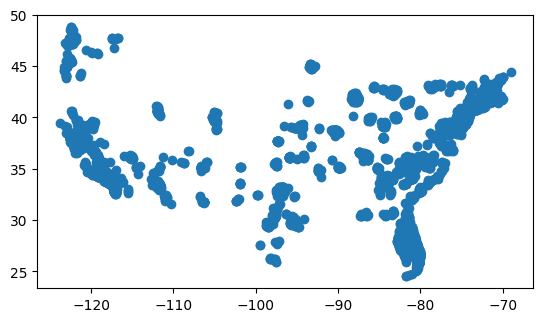

In [16]:
gdf.plot()

---

## Exports

#### CSV

In [17]:
df.to_csv("data/processed/bank_of_america_locations.csv", index=False)

#### JSON

In [18]:
df.to_json("data/processed/bank_of_america_locations.json", indent=4, orient="records")

#### GeoJSON

In [19]:
gdf.to_file("data/processed/bank_of_america_locations.geojson", driver="GeoJSON")